### The goal is to identify US states 

In [1]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

from numpy import array, array_equal, allclose
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pickle
import numpy as np
import pickle
import sys
sys.path.append(r'C:\Users\jiali\Desktop\Map_Identification_Classification\world map generation\getCartoCoordExtent')
from shapex import *
from geom.point import *
from geom.centroid import *

In [2]:
def edgeDetector(img):
    # img = cv2.imread(testImagePath + '\\'+imgName)
    font = cv2.FONT_HERSHEY_COMPLEX
    # legendPath = 'C:\\Users\\jiali\\Desktop\\MapElementDetection\\code\\Legend Analysis\\enhanced legend images'
    height = img.shape[0]
    width = img.shape[1]
    enlargeRatio = 1
    dim = (width*enlargeRatio, height*enlargeRatio)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray,(3,3),0)
    edge = cv2.Canny(gray, 50,200)
    # laplacian = cv2.Laplacian(gray,cv2.CV_8UC1)
    # Taking a matrix of size 5 as the kernel 
    kernel = np.ones((3,3), np.uint8) 

    n= 2
    for i in range(n):
        edge = cv2.dilate(edge, kernel, iterations=1) 
        edge = cv2.erode(edge, kernel, iterations=1) 
    
    cv2.imshow("shapes", edge)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return edge

In [3]:
def removeText(img, ocrResults):
    for ocr in ocrResults:
        bbox = ocr[0]
        xMin = int(bbox[0][0])
        yMin = int(bbox[0][1])
        xMax = int(bbox[2][0])
        yMax = int(bbox[2][1])
        value = img[yMax][xMax]

        for x in range(xMin,xMax):
            for y in range(yMin,yMax):
                img[y][x] = value
    # cv2.imshow("shapes", img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return img

In [4]:
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if array_equal(elem, myarr)), False)

def edgeDetector(img):
    # img = cv2.imread(testImagePath + '\\'+imgName)
    font = cv2.FONT_HERSHEY_COMPLEX
    # legendPath = 'C:\\Users\\jiali\\Desktop\\MapElementDetection\\code\\Legend Analysis\\enhanced legend images'
    height = img.shape[0]
    width = img.shape[1]
    enlargeRatio = 1
    dim = (width*enlargeRatio, height*enlargeRatio)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray,(3,3),0)
    edge = cv2.Canny(gray, 50,200)
    # laplacian = cv2.Laplacian(gray,cv2.CV_8UC1)
    # Taking a matrix of size 5 as the kernel 
    kernel = np.ones((3,3), np.uint8) 

    n= 2
    for i in range(n):
        edge = cv2.dilate(edge, kernel, iterations=1) 
        edge = cv2.erode(edge, kernel, iterations=1) 

    # contours, _ = cv2.findContours(
    #     edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # rectList = []  # used to save the rectangles
    # rectIndList = []  # save the min max XY value for extraction

    # for cnt in contours:
    #     approx = cv2.approxPolyDP(cnt, 0.1 * cv2.arcLength(cnt, True), True)
    #     cv2.drawContours(img, [approx], 0, (120, 120, 120), 1)
    #     x = approx.ravel()[0]
    #     y = approx.ravel()[1]

    #     if len(approx) >=3:

    #         test1 = approx[0][0][1]
    #         test2 = approx[2][0][1]
    #         if abs(test1 - test2) > 10:
    #             cv2.putText(img, "Rectangle", (x, y), font, 0.5, (0))
    #             if x >263 *3 and x < 270 * 3:
    #                 print(len(rectList))
    #             rectList.append(approx)
    # rectShapeBoxList = rectListToShapeBoxList(rectList)

    # # find out all rects intersecting with legendBbox and not intersecting with texts
    # legendRectShapeBoxList = []
    # for rectBox in rectShapeBoxList:
    #     isInterText = intersectText(rectBox,legendTextShapeBoxList)
    #     isInterLegend = legendShapeBox.intersects(rectBox)
    #     if isInterLegend and not isInterText:
    #         legendRectShapeBoxList.append(rectBox)

    # legendRectShapeBoxList = removeOverlappedBox(legendRectShapeBoxList) # postprocess to remove overlapped rect boxes
    
    # cv2.imshow("shapes", edge)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return edge

In [5]:
def getBackgroundColor(img1,imgGrey):
    # pick up background color
    (height, width, channel) = img1.shape
    heightList = range(10, height - 10, int((height - 20)/10))
    widthList = range(10, width - 10, int((width - 20)/10))
    samplePoints1 = [[10, w] for w in widthList]
    samplePoints2 = [[height - 10, w] for w in widthList]
    samplePoints3 = [[h, 10] for h in heightList]
    samplePoints4 = [[h, width - 10] for h in heightList]
    samplePoints = samplePoints1 + samplePoints2 + samplePoints3 + samplePoints4

    colorValues = []
    colorCounts = []
    for sp in samplePoints:
        colorValue = imgGrey[sp[0],sp[1]]
        if arreq_in_list(colorValue, colorValues) == False:
            colorValues.append(colorValue)
            colorCounts.append(1)
        else:
            index = colorValues.index(colorValue)
            colorCounts[index] += 1
    indexColorMost = colorCounts.index(max(colorCounts))
    bgColorValue = colorValues[indexColorMost]
    return bgColorValue

In [6]:
def getStateExtent(shp, country):
    for c in shp:
        x = c['properties']
        if c['properties']['NAME'] == country:
            break
    typeGeom = c['geometry']['type']
    coordGeom = c['geometry']['coordinates']
    minLat,maxLat, minLon, maxLon= 999999999, -999999999, 999999999, -999999999
    # if typeGeom != 'MultiPolygon':
    #     coordGeom = [coordGeom]
    
    for poly in coordGeom:
        if typeGeom != 'MultiPolygon':
            poly = [poly]
        tmpMinLon, tmpMaxLon = min(poly[0])[0], max(poly[0])[0]
        tmpMinLat, tmpMaxLat = min(poly[0], key = lambda t: t[1])[1], max(poly[0],key = lambda t: t[1])[1]
        if tmpMinLon < minLon:
            minLon = tmpMinLon
        if tmpMaxLon > maxLon:
            maxLon = tmpMaxLon
        if tmpMinLat < minLat:
            minLat = tmpMinLat
        if tmpMaxLat > maxLat:
            maxLat = tmpMaxLat

    return (minLon + maxLon)/2, (minLat + maxLat)/2

In [7]:
# get the point list of a state from the shapefile
def getPointList(shp, country):
    for c in shp:
        x = c['properties']
        if c['properties']['NAME'] == country:
            print('test')
            break
    typeGeom = c['geometry']['type']
    coordGeom = c['geometry']['coordinates']

    if typeGeom != 'MultiPolygon':
#         print(coordGeom[0]) 
        coordList = coordGeom[0]
    else:
        lenList = [len(poly[0]) for poly in coordGeom]
#         print(lenList)
        index = lenList.index(max(lenList))
#         print(index)
#         print(coordGeom[index]) 
        coordList = coordGeom[index][0]
    return [ Point(p[0], p[1]) for p in coordList ]

In [8]:
# get the centroid list of all states from the shapefile
def getCentroidStates(shp):
    centroidPointList = []
    for c in shp:
        typeGeom = c['geometry']['type']
        coordGeom = c['geometry']['coordinates']

        if typeGeom != 'MultiPolygon':
            coordList = coordGeom[0]
        else:
            lenList = [len(poly[0]) for poly in coordGeom]
            index = lenList.index(max(lenList))
            coordList = coordGeom[index][0]
        centroidPoint = centroid([Point(p[0], p[1]) for p in coordList])[1]
        centroidPointList.append(centroidPoint)
    return centroidPointList

In [9]:
# read detection results from pickle file
detectResultName = r'C:\Users\jiali\Desktop\MapElementDetection\code\postProcessingDetection\detectResultsOrigin.pickle'
with open(detectResultName, 'rb') as fDetectResults:
    detectResults = pickle.load(fDetectResults)

# read ocr results from pickle file
ocrResultName = r'C:\Users\jiali\Desktop\MapElementDetection\code\postProcessingDetection\ocrBoundsListOrigin.pickle'
with open(ocrResultName, 'rb') as fOCRResults:
    ocrResults = pickle.load(fOCRResults)

path = r'C:\Users\jiali\Desktop\MapElementDetection\dataCollection\USStateChoro\originalSize'
img1Name = '1_RR-cmQrDtwBSJKXIdJpshQ.png'

imgDetectResult = []
for dr in detectResults:
    if dr[0] == img1Name:
        imgDetectResult = dr

In [10]:
# read images and remove texts on the images
img1 = cv2.imread(path + '\\' + img1Name) # Image1 to be matched
# imgGrey = cv2.imread(path + '\\' + img1Name, 0) 
ocrImg1 = [ocr[1:] for ocr in ocrResults if ocr[0]==img1Name][0]
img1Proc = removeText(img1,ocrImg1)
imgGrey = cv2.cvtColor(img1Proc, cv2.COLOR_BGR2GRAY)
# get edge detection image
edge1 = edgeDetector(img1Proc)

In [11]:
img1Proc.shape

(1747, 2116, 3)

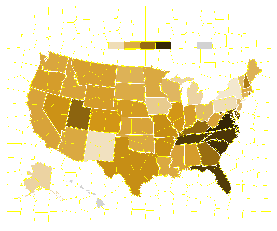

In [12]:
# loop over the number of segments
# apply SLIC and extract (approximately) the supplied number
# of segments
image = img_as_float(img1Proc)
numSegments = 300
# get segments from the segmentation results
segments = slic(image, n_segments = numSegments, sigma = 5)
# edgeSegments = edgeDetectorGrey(segments)
# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (numSegments))
ax = fig.add_subplot(1, 1, 1)
bounds = mark_boundaries(image, segments)
ax.imshow(bounds)
plt.axis("off")
# show the plots
plt.show()

bgColor = getBackgroundColor(img1Proc, imgGrey)

In [13]:
# get the list of pairs of coords of pixels with a specific superpixel segmentid
# index of the list means superpixel segmentid
maxSegmentationID = np.amax(segments)
minSegmentationID = np.amin(segments)

coordPairsList = [] 
for id in range(minSegmentationID,maxSegmentationID + 1):
    results = np.where(segments == id)
    coordPairs = np.asarray(results).T.tolist()
    # results = zip(*np.where(segments == id))
    # coord = zip(results)
    coordPairsList.append(coordPairs)

In [14]:
# identify whether the superpixel is with bg color
mapRegionSuperPixels = []
for coordPairs in coordPairsList:
    colorValueList = []
    for coordPair in coordPairs:
        colorValue = imgGrey[coordPair[0],coordPair[1]]
        colorValueList.append(colorValue)
        
    maxOccurValue = max(colorValueList,key=colorValueList.count)
    if abs(maxOccurValue - bgColor) > 10:
        mapRegionSuperPixels.append(coordPairs)

C:\Users\jiali\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.


In [15]:
# find super-pixels on the corners of US continent
maxXcoordList = []
maxXcoordPairList = []
maxYcoordList = []
maxYcoordPairList = []
minXcoordList = []
minXcoordPairList = []
minYcoordList = []
minYcoordPairList = []
for mapSuperPixel in mapRegionSuperPixels:
    maxXcoord = 0
    maxYcoord = 0
    minXcoord = 999999
    minYcoord = 999999
    for pairCoord in mapSuperPixel:
        if pairCoord[1] > maxXcoord:
            maxXcoord = pairCoord[1]
            maxXcoordPairList.append(pairCoord)
        if pairCoord[0] > maxYcoord and pairCoord[1] > image.shape[1]/4:
            maxYcoord = pairCoord[0]
            maxYcoordPairList.append(pairCoord)
        if pairCoord[1] < minXcoord and pairCoord[1] > 150:
            minXcoord = pairCoord[1]
            minXcoordPairList.append(pairCoord)
        if pairCoord[0] < minYcoord:
            minYcoord = pairCoord[0]
            minYcoordPairList.append(pairCoord)
    maxXcoordList.append(maxXcoord)
    maxYcoordList.append(maxYcoord)
    minXcoordList.append(minXcoord)
    minYcoordList.append(minYcoord)

In [16]:
maxXCoord = max(maxXcoordList)
indexRightSuperPixel = maxXcoordList.index(maxXCoord)
maxXCoordPair = maxXcoordPairList[indexRightSuperPixel]

maxYCoord = max(maxYcoordList)
indexBottomSuperPixel = maxYcoordList.index(maxYCoord)
maxYCoordPair = maxYcoordPairList[indexBottomSuperPixel]

minXCoord = min(minXcoordList)
indexLeftSuperPixel = minXcoordList.index(minXCoord)
minXCoordPair = minXcoordPairList[indexLeftSuperPixel]

minYCoord = min(minYcoordList)
indexTopSuperPixel = minYcoordList.index(minYCoord)
minYCoordPair = minYcoordPairList[indexTopSuperPixel]

deltaImgX =  maxXCoord - minXCoord
deltaImgY =  maxYCoord - minYCoord

In [17]:
MaineSuperPixel = mapRegionSuperPixels[indexRightSuperPixel]
WashingtonSuperPixel = mapRegionSuperPixels[indexTopSuperPixel]
TexasSuperPixel = mapRegionSuperPixels[indexBottomSuperPixel]

for coordPair in MaineSuperPixel+WashingtonSuperPixel+TexasSuperPixel:
    imgGrey[coordPair[0],coordPair[1]] = 0

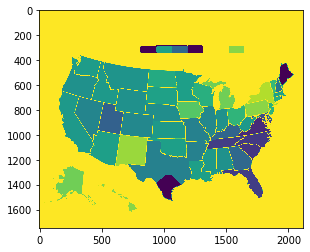

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(imgGrey)
plt.show()

In [19]:
# get the real corner geographic coordinates
shapefilePath = r'C:\Users\jiali\Desktop\MapElementDetection\code\shpFiles\USA_Contiguous_Albers_Equal_Area_Conic'

fileName = 'USA_Contiguous_Albers_Equal_Area_Conic.shp'
shp = shapex(shapefilePath + '\\' + fileName)
x1, y1, x2, y2 = shp.bounds
deltaGeoX = x2 - x1
deltaGeoY = y2 - y1

In [20]:
x1, y1, x2, y2

(-2356113.742900001,
 -1338125.3953999998,
 2258154.4408999984,
 1558935.3896000008)

In [21]:
centroidList = getCentroidStates(shp)

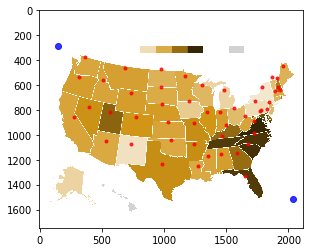

In [22]:
# xImgState = minXCoord + (xGeoState - x1) / deltaGeoX * deltaImgX
# yImgState = minYCoord + (y2 - yGeoState ) / deltaGeoY * deltaImgY
fig = plt.figure()
ax = plt.gca()
ax.scatter(minXCoord, minYCoord, color='blue', marker='o', alpha=0.8)
ax.scatter(maxXCoord, maxYCoord, color='blue', marker='o', alpha=0.8)

for centroidGeo in centroidList:
    xCentroidGeo = centroidGeo.x
    yCentroidGeo = centroidGeo.y
    xImgState = minXCoord + (xCentroidGeo - x1) / deltaGeoX * deltaImgX
    yImgState = minYCoord + (y2 - yCentroidGeo ) / deltaGeoY * deltaImgY
    ax.scatter(xImgState, yImgState, color='red', marker='.', alpha=0.8)
ax.imshow(img1)
plt.show()



In [308]:
xGeoState, yGeoState

(1107700.3293500002, 394283.80129999947)

In [309]:
xImgState,yImgState

(819.7466653561328, 505.18457688733434)

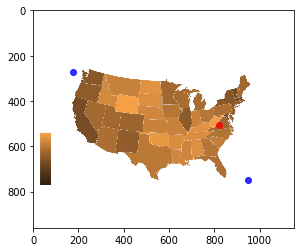

In [300]:
RGBState = img1Proc[int(yImgState), int(xImgState),:]
RGBState

array([136,  88,  41], dtype=uint8)

In [105]:
img1Proc[480, 500,:]

array([215, 171, 128], dtype=uint8)